In [2]:
import nltk
nltk.download('conll2002')
from nltk.corpus import conll2002
train_es = conll2002.iob_sents('esp.train') # Train
dev_es = conll2002.iob_sents('esp.testa') # Dev
test_es =conll2002.iob_sents('esp.testb') # Test

train_ned = conll2002.iob_sents('ned.train') # Train
dev_ned = conll2002.iob_sents('ned.testa') # Dev
test_ned =conll2002.iob_sents('ned.testb') # Test

data = {'spanish': (train_es, dev_es, test_es),
        'dutch': (train_ned, dev_ned, test_ned)}

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [3]:
train = conll2002.tagged_sents('esp.train')
test = conll2002.tagged_sents('esp.testb')
print(len(train))

8323


In [41]:
import json

# Leer nombres de personas
person_names_list = set()
for fname in ['esp_names.txt', 'hol_names.txt']:
    try:
        with open(fname, encoding='utf-8') as f:
            person_names_list.update(line.strip().lower() for line in f if line.strip())
    except Exception as e:
        print(f"Error leyendo {fname}: {e}")

# Leer ciudades y países
locations_list = set()
def add_names_from_json(path, key):
    try:
        with open(path, encoding='utf-8-sig') as f:
            data = json.load(f)
            if isinstance(data, dict) and key in data:
                for item in data[key]:
                    if isinstance(item, dict) and "name" in item:
                        locations_list.add(item["name"].lower())
                    elif isinstance(item, str):
                        locations_list.add(item.lower())
            elif isinstance(data, list):
                for item in data:
                    if isinstance(item, dict) and "name" in item:
                        locations_list.add(item["name"].lower())
                    elif isinstance(item, str):
                        locations_list.add(item.lower())
    except Exception as e:
        print(f"Error leyendo {path}: {e}")

add_names_from_json('cities.json', 'cities')
add_names_from_json('countries.json', 'countries')


In [42]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemma(word):
    return lemmatizer.lemmatize(word)

def pos_tag(word):
    tagged = nltk.pos_tag([word])
    return tagged[0][1]

def generate_features(feature_selection):
    def feature_function(sentence, index):
        features = {"bias": 1.0}  # Bias term for the feature vector
        word = sentence[index][0]  # Always get the first element (word)
        
        # Características básicas de la palabra
        if feature_selection.get("word_form", True):
            features.update({
                "word": word,
                "word.lower": word.lower(),
            })

        # Características morfológicas
        if feature_selection.get("morphology", True):
            features.update({
                "word.istitle": word.istitle(),
                "word.isupper": word.isupper(),
                "word.islower": word.islower(),
                "word.isdigit": word.isdigit(),
                "has_digit": any(c.isdigit() for c in word),
                "capitals_inside": any(c.isupper() for c in word[1:]),
                "has_symbol": not word.isalnum()
            })
        
        # POS tagging y lemas
        if feature_selection.get("lemma_pos_tags", True):
            features["pos_tag"] = pos_tag(word)
            features["lemma"] = lemma(word)
        
        # Prefijos y sufijos
        if feature_selection.get("prefix_suffix", True):
            features.update({
                "prefix3": word[:3],
                "suffix3": word[-3:],
                "prefix2": word[:2],
                "suffix2": word[-2:],
            })
        
        # Longitud de la palabra
        if feature_selection.get("length", True):
            features["length"] = len(word)
        
        # Posición en la oración
        if feature_selection.get("position", True):
            features.update({
                "position": index,
                "is_first": index == 0,
                "is_last": index == len(sentence)-1
            })
        
        # Contexto circundante
        if feature_selection.get("context", True):
            if index > 0:
                prev_word = sentence[index-1][0]
                features.update({
                    "prev_word.lower": prev_word.lower(),
                    "prev_word.istitle": prev_word.istitle(),
                    "prev_word.isupper": prev_word.isupper(),
                    "prev_word.isdigit": prev_word.isdigit(),
                    "prev_word.istitle": prev_word.istitle()})
                
                if feature_selection.get("lemma_pos_tags", True):
                    features["prev_lemma"] = lemma(prev_word)
                    features["prev_pos_tag"] = pos_tag(prev_word)

            if index < len(sentence)-1:
                next_word = sentence[index+1][0]
                features.update({
                    "next_word.lower": next_word.lower(),
                    "next_word.istitle": next_word.istitle(),
                    "next_word.isupper": next_word.isupper(),
                    "next_word.isdigit": next_word.isdigit(),
                    "next_word.istitle": next_word.istitle()})
                
                if feature_selection.get("lemma_pos_tags", True):
                    features["next_lemma"] = lemma(next_word)
                    features["next_pos_tag"] = pos_tag(next_word)
        
        # Patrones de fecha y hora
        if feature_selection.get("date_time_patterns", True):
            date_pattern = r"\d{1,2}[/-]\d{1,2}([/-]\d{2,4})?"
            time_pattern = r"\d{1,2}:\d{2}(:\d{2})?"
            features["has_date_pattern"] = bool(re.search(date_pattern, word))
            features["has_time_pattern"] = bool(re.search(time_pattern, word))

        # Caracteres especiales y símbolos
        if feature_selection.get("symbol_patterns", True):
            features.update({
            "has_hyphen": "-" in word,
            "has_dot": "." in word,
            "has_comma": "," in word,
            "has_slash": "/" in word,
            "has_percent": "%" in word,
            "has_currency": any(c in word for c in "$€£¥"),
            "has_at": "@" in word
            })

                # En generate_features, añadir:
        if feature_selection.get("gazetteers", True):
            features.update({
                "in_locations": word.lower() in locations_list,
                "in_person_names": word.lower() in person_names_list
            })
        
        return features
    
    return feature_function

In [43]:
feature_selection = {
    "word_form": True,           # Basic word characteristics
    "prefix_suffix": True,       # Prefixes and suffixes
    "morphology": True,          # Morphological features
    "context": True,             # Surrounding words
    "lemma_pos_tags": True,      # POS tagging and lemmas
    "date_time_patterns": True,  # Date and time patterns
    "symbol_patterns": True,     # Special characters
    "length": True,              # Word length features
    "position": True,            # Position features
    "gazetteers": True           # Gazetteer features
}

ct = nltk.tag.CRFTagger(feature_func=generate_features(feature_selection))
ct.train(train[:100], "nooooooolapolitziiaa.mdl")
ct.accuracy(test)

0.6670094890652591

In [ ]:
import nltk
from nltk.corpus import conll2002
from nltk.tag import CRFTagger
from typing import List, Tuple, Optional, Callable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score

nltk.download('conll2002')

class CRFModel:
    # Clase proporcionada por el usuario (como en el enunciado)
    def __init__(self, train, test, model_file: Optional[str] = None, features: Optional[Callable] = None, encoding: str = 'bio') -> None:
        self.model = CRFTagger(feature_func=features)
        self.model_file = model_file
        self.encoding = encoding
        self.train_data = self.transformar_dades(train)
        self.test_data = self.transformar_dades(test)

    def transformar_dades(self, data):
        if self.encoding == 'io':
            #data_encoded = [self.to_io(sent) for sent in data] 
            data_encoded = self.to_io(data)
        elif self.encoding == 'bioes':
            #data_encoded = [self.to_bioes(sent) for sent in data]
            data_encoded = self.to_bioes(data)
        elif self.encoding == 'biow':
            #data_encoded = [self.to_biow(sent) for sent in data]
            data_encoded = self.to_biow(data)
        else:
            data_encoded = data
        return data_encoded

    def train(self, train_data: List[List[Tuple[str, str]]]) -> None:
        self.model.train(train_data, self.model_file)

    def predict(self, sents: List[List[Tuple[str, str]]]) -> List[List[Tuple[str, str]]]:
        if self.model_file:
            self.model.set_model_file(self.model_file)
        words_test = [[word for (word, _) in sent] for sent in sents]
        return self.model.tag_sents(words_test)
    
    def to_biow(self, tagged_sents):
   
        biow_tagged_sents = []
        
        for sent in tagged_sents:
            biow_sent = []
            i = 0
            while i < len(sent):
                word = sent[i][0]  # Get the word
                tag = sent[i][-1]  # Get the BIO tag
                
                # If it's a B- tag, check if it's a single token entity
                if tag.startswith('B-'):
                    entity_type = tag[2:]  # Get entity type (PER, LOC, etc.)
                    
                    # Check if next token continues this entity
                    if i + 1 < len(sent) and sent[i+1][-1] == f'I-{entity_type}':
                        # Multi-token entity, keep as B-
                        biow_sent.append((word, tag))
                    else:
                        # Single token entity, convert to W-
                        biow_sent.append((word, f'W-{entity_type}'))
                else:
                    # Keep I- and O tags as they are
                    biow_sent.append((word, tag))
                    
                i += 1
                
            biow_tagged_sents.append(biow_sent)
        
        return biow_tagged_sents
    
    def to_io(self,tagged_sents):
        io_tagged_sents = []
        
        for sent in tagged_sents:
            io_sent = []
            for token in sent:
                word = token[0]  # Get the word
                tag = token[-1]  # Get the BIO tag
                
                # Convert B- to I- (Beginning to Inside)
                if tag.startswith('B-'):
                    tag = 'I-' + tag[2:]
                    
                io_sent.append((word, tag))
            io_tagged_sents.append(io_sent)
        
        return io_tagged_sents
        
    def to_bioes(self,tagged_sents):
        bioes_tagged_sents = []
        
        for sent in tagged_sents:
            bioes_sent = []
            i = 0
            while i < len(sent):
                word = sent[i][0]  # Get the word
                tag = sent[i][-1]  # Get the BIO tag
                
                # Handle outside tags (O)
                if tag == 'O':
                    bioes_sent.append((word, tag))
                    i += 1
                    continue
                
                # Handle entity tags (B-X or I-X)
                if tag.startswith('B-'):
                    entity_type = tag[2:]  # Get entity type (PER, LOC, etc.)
                    
                    # Find the end of this entity
                    end_idx = i + 1
                    while (end_idx < len(sent) and 
                        sent[end_idx][-1] == f'I-{entity_type}'):
                        end_idx += 1
                    
                    # Single-token entity (B-X not followed by I-X)
                    if end_idx == i + 1:
                        bioes_sent.append((word, f'S-{entity_type}'))
                    else:
                        # Add B- tag for beginning
                        bioes_sent.append((word, tag))
                        
                        # Add I- tags for middle tokens (if any)
                        for j in range(i+1, end_idx-1):
                            word_j = sent[j][0]
                            bioes_sent.append((word_j, f'I-{entity_type}'))
                        
                        # Add E- tag for the end token
                        word_end = sent[end_idx-1][0]
                        bioes_sent.append((word_end, f'E-{entity_type}'))
                    
                    i = end_idx
                    
                elif tag.startswith('I-'):
                    # This is an error case - I- tag without preceding B-
                    # We'll treat it as B- for robustness
                    entity_type = tag[2:]
                    
                    # Find the end of this entity
                    end_idx = i + 1
                    while (end_idx < len(sent) and 
                        sent[end_idx][-1] == f'I-{entity_type}'):
                        end_idx += 1
                    
                    # Single-token entity (just this I-X)
                    if end_idx == i + 1:
                        bioes_sent.append((word, f'S-{entity_type}'))
                    else:
                        # Add B- tag for beginning (correcting the I- error)
                        bioes_sent.append((word, f'B-{entity_type}'))
                        
                        # Add I- tags for middle tokens (if any)
                        for j in range(i+1, end_idx-1):
                            word_j = sent[j][0]
                            bioes_sent.append((word_j, f'I-{entity_type}'))
                        
                        # Add E- tag for the end token
                        word_end = sent[end_idx-1][0]
                        bioes_sent.append((word_end, f'E-{entity_type}'))
                    
                    i = end_idx
                else:
                    # Unknown tag type, pass through unchanged
                    bioes_sent.append((word, tag))
                    i += 1
                    
            bioes_tagged_sents.append(bioes_sent)
        
        return bioes_tagged_sents
    # Resto de métodos (to_bioes, to_io, extraccio_entitats, evaluacio_entitats, matriu_confusio) como en el enunciado

    def extraccio_entitats(self, tagged_sentences):
        """
        Extrae entidades de oraciones etiquetadas en formato BIO/IO/BIOES/BIOW.
        Devuelve una lista de tuplas (tipo_entidad, texto_entidad).
        """
        entities = []
        
        for sent in tagged_sentences:
            i = 0
            while i < len(sent):
                word, tag = sent[i]
                
                # Si es una etiqueta O, pasa a la siguiente palabra
                if tag == 'O':
                    i += 1
                    continue
                    
                # Extraer tipo de entidad (PER, LOC, ORG, etc.)
                if '-' in tag:
                    prefix, entity_type = tag.split('-', 1)
                else:
                    entity_type = tag  # En caso de formato extraño
                    prefix = tag[0] if tag else 'O'
                    
                # Determinar inicio y fin de la entidad según el esquema
                if prefix in ('B', 'S', 'W', 'I'):  # Cualquier inicio de entidad
                    # Buscar el final de la entidad
                    start_idx = i
                    end_idx = i + 1
                    
                    # Si es un esquema con continuación (B-X seguido de I-X)
                    if prefix in ('B', 'I'):
                        while (end_idx < len(sent) and 
                            sent[end_idx][1].startswith('I-') and 
                            sent[end_idx][1].split('-', 1)[1] == entity_type):
                            end_idx += 1
                    
                    # Extraer texto de la entidad (todas las palabras juntas)
                    entity_text = ' '.join([sent[j][0] for j in range(start_idx, end_idx)])
                    entities.append((entity_type, entity_text))
                    
                    i = end_idx
                else:
                    # Etiqueta desconocida, pasar a la siguiente palabra
                    i += 1
                    
        return entities
    
    def sent_tags_to_IO(sent_tags):
        '''
        Convert sentence tags to IO format
        
        :param sent_tags: list of tags
        :type sent_tags: list(str)
        :return: list of IO tags
        :rtype: list(str)
        '''
        io_sent_tags = []
        for sent in sent_tags:
            tags = [re.sub(r'\b[BES]-', 'I-', tag) for tag in sent]
            io_sent_tags.append(tags)
        return io_sent_tags

    def evaluacio_entitats(self, y_true, y_pred, features=[0,0,0,0], errors=False):
        """
        Evalúa las predicciones de entidades usando el criterio personalizado.
        Calcula balanced accuracy y métricas por tipo de entidad.
        """
        # y_true y y_pred deben ser listas de oraciones etiquetadas (list of list of (word, tag))
        # features y errors se pasan a la función de evaluación personalizada

        # Se asume que las funciones sent_tags_to_IO y entity_finder están definidas en el entorno,
        # así como balanced_accuracy_score.

        info = {'Codification': features, 'Balanced accuracy': 0, 'Total entities': 0, 'Entities correct': 0, 'LOC correct': 0, 'MISC correct': 0, 'ORG correct': 0, 'PER correct': 0, 'Entities invented': 0}
        
        sent_io_real = self.sent_tags_to_IO(y_true)
        sent_io_pred = self.sent_tags_to_IO(y_pred)

        def join_sent_tags(sent_tags):
            return [tag[0] for sent in sent_tags for tag in sent]

        # Calcula la precisión balanceada
        info['Balanced accuracy'] = balanced_accuracy_score(join_sent_tags(sent_io_real), join_sent_tags(sent_io_pred))

        real_entities = self.extraccio_entitats(sent_io_real)
        pred_entities = self.extraccio_entitats(sent_io_pred)
        total_ent = 0
        total_loc = 0
        total_misc = 0
        total_org = 0
        total_per = 0

        for sent in real_entities:
            for entity in sent:
                total_ent += 1
                if entity[0] == 'LOC':
                    total_loc += 1
                if entity[0] == 'MISC':
                    total_misc += 1
                if entity[0] =='ORG':
                    total_org += 1
                if entity[0] == 'PER':
                    total_per += 1

        info['Total entities'] = total_ent

        good_ent = 0
        good_loc = 0
        good_misc = 0
        good_org = 0
        good_per = 0
        invented_ent = 0

        for i in range(0, len(real_entities)):
            for entity in pred_entities[i]:
                if entity in real_entities[i]:
                    good_ent += 1
                    if entity[0] == 'LOC':
                        good_loc += 1
                    if entity[0] == 'MISC':
                        good_misc += 1
                    if entity[0] =='ORG':
                        good_org += 1
                    if entity[0] == 'PER':
                        good_per += 1
                else:
                    invented_ent += 1

        info['Entities correct'] = good_ent/total_ent if total_ent > 0 else 0.0
        info['LOC correct'] = good_loc/total_loc if total_loc > 0 else 0.0
        info['MISC correct'] = good_misc/total_misc if total_misc > 0 else 0.0
        info['ORG correct'] = good_org/total_org if total_org > 0 else 0.0
        info['PER correct'] = good_per/total_per if total_per > 0 else 0.0

        info['Entities invented'] = invented_ent

        if errors:
            errors_list = []
            invented_list = []
            for i in range(0, len(real_entities)):
                for entity in pred_entities[i]:
                    if entity not in real_entities[i]:
                        errors_list.append((i, entity))
            for i in range(0, len(pred_entities)):
                for entity in real_entities[i]:
                    if entity not in pred_entities[i]:
                        invented_list.append((i, entity))
            return info, errors_list, invented_list
                    
        return info
    
    def matriu_confusio(self, y_true, y_pred):
        """
        Genera y visualiza una matriz de confusión para las entidades.
        """
        true_types = set(entity_type for entity_type, _ in y_true)
        pred_types = set(entity_type for entity_type, _ in y_pred)
        entity_types = sorted(true_types.union(pred_types))
        
        # Crear dataframe para la matriz de confusión
        confusion_matrix = pd.DataFrame(0, index=entity_types, columns=entity_types)
        
        # Contar coincidencias (true positives)
        true_dict = {}
        for entity_type, text in y_true:
            if (entity_type, text) not in true_dict:
                true_dict[(entity_type, text)] = 0
            true_dict[(entity_type, text)] += 1
        
        pred_dict = {}
        for entity_type, text in y_pred:
            if (entity_type, text) in true_dict:
                # Si la entidad existe en y_true, es un true positive
                true_entity_type, _ = (entity_type, text)
                confusion_matrix.loc[true_entity_type, entity_type] += 1
            else:
                # Si no existe, es un false positive
                if entity_type in entity_types:
                    for true_type in entity_types:
                        if true_type != entity_type:
                            confusion_matrix.loc[true_type, entity_type] += 1
                            break
        
        # Visualizar matriz
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Matriz de confusión de entidades')
        plt.ylabel('Valor real')
        plt.xlabel('Predicción')
        plt.tight_layout()
        
        return confusion_matrix

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [45]:
class NERCRF:
    def __init__(self, language: str = 'esp', encoding: str = 'bio', feature_func: Optional[Callable] = None, model_file: Optional[str] = None):
        self.language = language
        self.encoding = encoding
        self.feature_func = feature_func
        self.model_file = model_file

        # Cargar datos
        # Importar datos desde la clase usando nltk.corpus.conll2002
        self.train_raw, self.dev_raw, self.test_raw = self.load_data()

        # Inicializar modelo CRF
        self.crf_model = CRFModel(
            train=self.train_raw,
            test=self.test_raw,
            model_file=self.model_file,
            features=self.feature_func,
            encoding=self.encoding
        )

    def load_data(self):
        train_data = conll2002.iob_sents(self.language+'.train')
        dev_data = conll2002.iob_sents(self.language+'.testa')
        test_data = conll2002.iob_sents(self.language+'.testb')


        return train_data, dev_data, test_data

    def train_model(self):
        self.crf_model.train(self.crf_model.train_data)

    def evaluate(self, split: str = 'dev') -> Tuple[float, float, float]:
        if split == 'dev':
            data = self.dev_raw
        elif split == 'test':
            data = self.test_raw
        else:
            raise ValueError("split debe ser 'dev' o 'test'")

        # Transformar datos al encoding correcto
        data_encoded = self.crf_model.transformar_dades(data)

        # Predecir etiquetas
        predicted = self.crf_model.predict(data_encoded)

        # Extraer entidades
        y_true = []
        for sent in data_encoded:
            entities = self.crf_model.extraccio_entitats([sent])
            y_true.extend(entities)

        y_pred = []
        for sent in predicted:
            entities = self.crf_model.extraccio_entitats([sent])
            y_pred.extend(entities)

        # Evaluar
        recall, precision, f1 = self.crf_model.evaluacio_entitats(y_true, y_pred)
        return recall, precision, f1

    def predict_sentence(self, sentence: List[str]) -> List[Tuple[str, str]]:
        formatted_sent = [[(word, 'O') for word in sentence]]
        predicted = self.crf_model.predict(formatted_sent)
        return predicted[0]
    
    def matriu_confusio(self, data=None, split='dev'):
        """
        Genera una matriz de confusión para evaluar el modelo.
        
        Args:
            data: Datos específicos a evaluar (opcional)
            split: 'dev' o 'test' para usar conjuntos predefinidos
        """
        if data is None:
            if split == 'dev':
                data = self.dev_raw
            elif split == 'test':
                data = self.test_raw
            else:
                raise ValueError("split debe ser 'dev' o 'test'")
        
        # Transformar datos al encoding correcto
        data_encoded = self.crf_model.transformar_dades(data)
        
        # Predecir etiquetas
        predicted = self.crf_model.predict(data_encoded)
        
        # Extraer entidades para y_true y y_pred
        y_true = []
        for sent in data_encoded:
            entities = self.crf_model.extraccio_entitats([sent])
            y_true.extend(entities)
        
        y_pred = []
        for sent in predicted:
            entities = self.crf_model.extraccio_entitats([sent])
            y_pred.extend(entities)
        
        # Crear matriz de confusión
        return self.crf_model.matriu_confusio(y_true, y_pred)

Resultados para español (BIOES):
Recall: 0.14, Precision: 0.03, F1: 0.05
Resultados para neerlandés (IO):
Recall: 0.00, Precision: 0.00, F1: 0.00


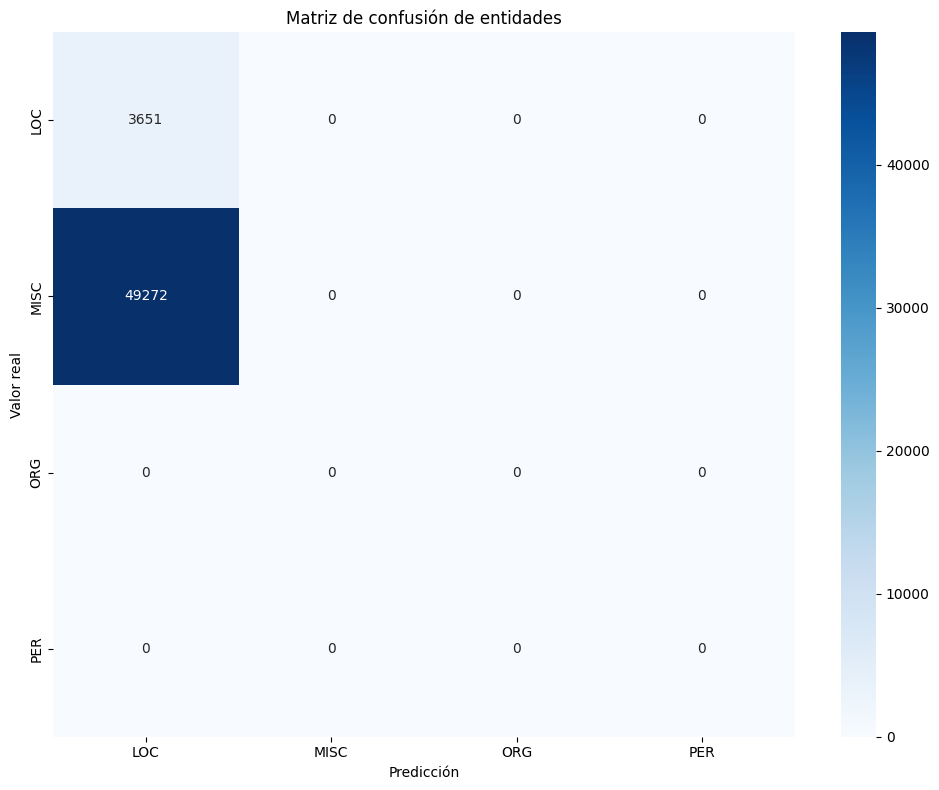

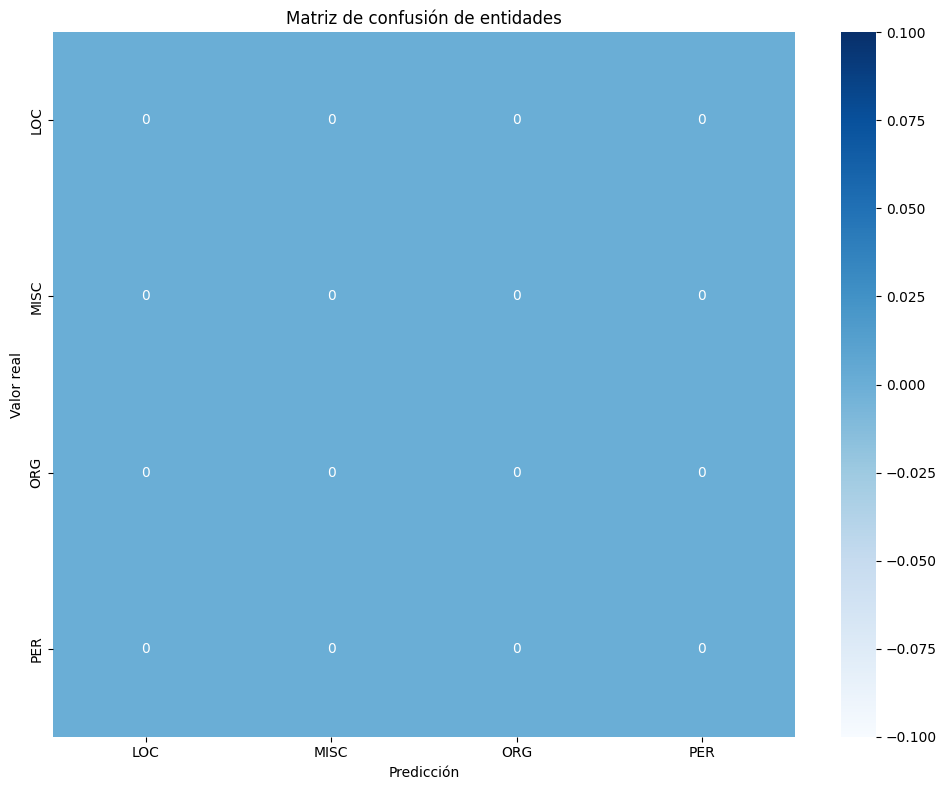

In [46]:
# Define tu selección de características
feature_selection = {
    "word_form": True,           # Basic word characteristics
    "prefix_suffix": True,       # Prefixes and suffixes
    "morphology": True,          # Morphological features
    "context": True,             # Surrounding words
    "lemma_pos_tags": True,      # POS tagging and lemmas
    "date_time_patterns": True,  # Date and time patterns
    "symbol_patterns": True,     # Special characters
    "length": True,              # Word length features
    "position": True,            # Position features
    "gazetteers": True           # Gazetteer features
}

# Genera la función de características con tus ajustes
feature_func = generate_features(feature_selection)

# Entrenar modelo para español con BIOES usando tus características avanzadas
spanish_model = NERCRF(
    language='esp',
    encoding='bioes',
    feature_func=feature_func,  # Usa tu función más completa
    model_file='esp_model.crf'
)
spanish_model.train_model()
recall, precision, f1 = spanish_model.evaluate('dev')
spanish_model.matriu_confusio(split='dev')
print(f"Resultados para español (BIOES):\nRecall: {recall:.2f}, Precision: {precision:.2f}, F1: {f1:.2f}")

# Entrenar modelo para neerlandés con IO usando tus características avanzadas
dutch_model = NERCRF(
    language='ned',
    encoding='io',
    feature_func=feature_func,  # Usa la misma función
    model_file='ned_model.crf'
)
dutch_model.train_model()
recall, precision, f1 = dutch_model.evaluate('test')
dutch_model.matriu_confusio(split='test')
print(f"Resultados para neerlandés (IO):\nRecall: {recall:.2f}, Precision: {precision:.2f}, F1: {f1:.2f}")

# Extra: Cadec Corpus

In [1]:
import pyconll
import os

# Adjust working with CADEC-specific data
def load_cadec_data(filepath):
    """Load CADEC data and extract entity types (ADR, Di, Dr, S, F)"""
    sentences = []
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            raw_text = f.read()
        
        # Split into sentences (assuming one sentence per line or blank line separation)
        raw_sents = [s.strip() for s in raw_text.split('\n\n') if s.strip()]
        
        for sent in raw_sents:
            tokens = []
            for line in sent.split('\n'):
                if line.strip():
                    # Assuming CoNLL format: token pos chunk tag
                    parts = line.split()
                    if len(parts) >= 4:  # Ensure we have enough columns
                        word = parts[0]
                        tag = parts[3]  # Entity tag (O, B-ADR, I-ADR, etc.)
                        
                        # Strip the identifier, keep only entity type
                        if tag != 'O' and '-' in tag:
                            prefix, entity_type = tag.split('-', 1)
                            # Keep only the entity type (ADR, Di, Dr, S, F), remove identifiers
                            if '+' in entity_type:
                                entity_type = entity_type.split('+')[0]
                            tag = f"{prefix}-{entity_type}"
                        
                        tokens.append((word, tag))
            
            if tokens:
                sentences.append(tokens)
    
    except Exception as e:
        print(f"Error loading CADEC data: {e}")
        return []
    
    return sentences




ModuleNotFoundError: No module named 'pyconll'

In [1]:
train_data = load_cadec_data('./cadec/train.conll')
test_data = load_cadec_data('./cadec/test.conll')

NameError: name 'load_cadec_data' is not defined